<!-- Copyright 2015 Google Inc. All rights reserved. -->

<!-- Licensed under the Apache License, Version 2.0 (the "License"); -->
<!-- you may not use this file except in compliance with the License. -->
<!-- You may obtain a copy of the License at -->

<!--     http://www.apache.org/licenses/LICENSE-2.0 -->

<!-- Unless required by applicable law or agreed to in writing, software -->
<!-- distributed under the License is distributed on an "AS IS" BASIS, -->
<!-- WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. -->
<!-- See the License for the specific language governing permissions and -->
<!-- limitations under the License. -->

# Visualizing Regional Linkage Disequilibrium Results
This notebook demonstrates visualization of linkage disequilibrium (LD) data stored as publicly accessible BigQuery datasets.
Specifically, we will work with LD calculated on the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) variants. The source variants were imported to Google Genomics and then LD calculations were performed and the resulting dataset exported to BigQuery using pipelines in the https://github.com/googlegenomics/linkage-disequilibrium project.

If you want to explore more linkage disequilibrium samples, see https://github.com/googlegenomics/linkage-disequilibrium/tree/master/datalab. For general genomics examples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Datalab instance by uploading them while on the notebook list page.

**NOTE: Some plots in this notebook are memory-intensive, and may not run on a standard Datalab instance.** See https://cloud.google.com/datalab/getting-started for information on how to use a larger-memory instance.

In [1]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt

The [initial LD exploration Datalab](https://github.com/googlegenomics/linkage-disequilibrium/blob/master/datalab/Exploring_Linkage_Disequilibrium_Data.ipynb) indicated that LD is best analyzed on a population-specific level. Consequently, we load data for subpopulations directly.

In [2]:
# Get references to the BigQuery tables of linkage disequilibrium
# in the five superpopulations of the 1000 Genomes Project
# (http://www.1000genomes.org/faq/which-populations-are-part-your-study):
# AMR: Admixed American
# AFR: African
# EUR: European
# SAS: South Asian
# EAS: East Asian
populations = {
  "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
  "AMR": ["CLM", "MXL", "PEL", "PUR"],
  "EAS": ["CDX", "CHB", "CHS", "JPT", "KHV"],
  "EUR": ["CEU", "FIN", "GBR", "IBS", "TSI"],
  "SAS": ["BEB", "GIH", "ITU", "PJL", "STU"],
}

def get_ld_tablename(population):
  """Returns the name of the BigQuery table with the publicly-available LD data."""
  is_subpopulation = population not in populations
  pop = "sub_pop_%s" % population if is_subpopulation else "super_pop_%s" % population
  return "genomics-public-data:linkage_disequilibrium_1000G_phase_3.%s" % pop

# The superpopulations we want to examine in this analysis.
SUPERPOPULATIONS = ["AFR", "EUR"]

tables = {}
for superpopulation in SUPERPOPULATIONS:
  subpopulations = populations[superpopulation]
  
  for subpopulation in subpopulations:
    # Only load the subpopulations for this analysis.
    tables[subpopulation] = bq.Table(get_ld_tablename(subpopulation))

tables.keys()

['ACB',
 'ASW',
 'GWD',
 'TSI',
 'YRI',
 'LWK',
 'CEU',
 'MSL',
 'GBR',
 'ESN',
 'IBS',
 'FIN']

## Focusing on specific subsets of all linkage disequilibrium results
Below we will load the LD results from BigQuery for specific, relatively small regions of the genome that we want to visualize.

In [3]:
# Identify genomic regions of interest.
# A random area of the genome.
chr20_region = ("20", 10000000, 10300000)
# An area surrounding a gene involved in lactase persistence, which was positively selected
# for in Europeans (http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3048992/). 
lactase_region = ("2", 136450000, 136750000)

In [4]:
%%sql --module ld_results
SELECT
  qstart,
  tstart,
  corr * corr AS rsquared
FROM $all_ld_table
WHERE
  qchrom = $chromosome AND
  qstart < tstart AND
  qstart >= $start AND
  tstart <= $end

The LD results we've loaded have chromosomal positions and the measure of LD. Since variants occur far from each other in physical space, it is useful to order them by their index when sorted by chromosomal position for the purposes of visualization.

In [5]:
# Load chr20 region LD results for all African and European subpopulations.
chr20_region_ld_results = {}
chrom, start, end = chr20_region
for superpopulation in SUPERPOPULATIONS:
  chr20_region_ld_results[superpopulation] = {}
  for subpopulation in populations[superpopulation]:
    table = tables[subpopulation]
    result = bq.Query(ld_results,
                      all_ld_table=table,
                      chromosome=chrom,
                      start=start,
                      end=end).to_dataframe()
    chr20_region_ld_results[superpopulation][subpopulation] = result

In [6]:
# Load lactase persistence region LD results for all African and European subpopulations.
lactase_region_ld_results = {}
chrom, start, end = lactase_region
for superpopulation in SUPERPOPULATIONS:
  lactase_region_ld_results[superpopulation] = {}
  for subpopulation in populations[superpopulation]:
    table = tables[subpopulation]
    result = bq.Query(ld_results,
                      all_ld_table=table,
                      chromosome=chrom,
                      start=start,
                      end=end).to_dataframe()
    lactase_region_ld_results[superpopulation][subpopulation] = result

In [7]:
# Find the index of each position in the output.
def add_indices(df_list):
  """Adds the index of each position as an attribute of all dataframes in the list."""
  # Find the index of every position represented in at least one of the dataframes
  unique_positions = set()
  for df in df_list:
    unique_positions = unique_positions.union(df["qstart"]).union(df["tstart"])
  sorted_positions = sorted(unique_positions)
  indices = pd.DataFrame(range(len(sorted_positions)), index=sorted_positions)
  # Add the indexes to each dataframe
  for df in df_list:
    df["qindex"] = list(indices.loc[df["qstart"]][0])
    df["tindex"] = list(indices.loc[df["tstart"]][0])

In [8]:
# Add indices to the chr20 region data.
chr20_afr = chr20_region_ld_results["AFR"]
chr20_eur = chr20_region_ld_results["EUR"]
add_indices(chr20_afr.values() + chr20_eur.values())

# Add indices to the lactase region data.
lactase_afr = lactase_region_ld_results["AFR"]
lactase_eur = lactase_region_ld_results["EUR"]
add_indices(lactase_afr.values() + lactase_eur.values())

The following function defines a plotting method that can be used to visualize the pairwise LD results as a triangle plot.

In [9]:
# Plot the structure of the LD data
import math
import matplotlib
import matplotlib.pyplot as plt

def plot_ld_figure(ld_dict, title=None):
  """Plots a triangle plot of LD results for a single region in multiple populations.
  
  Args:
    ld_dict: A dictionary keyed by population with value a pandas DataFrame of LD in that population.
    title: A title for the plot.
  """
  fig = plt.figure()
  
  # The colormap we use to shade LD in all subplots.
  cmap = matplotlib.cm.get_cmap("Reds")

  # The scaling we apply to variant index values to create an upward-pointing triangle plot.
  scale = 0.5
  def plot_subplot(alldata, location, population, label=False):
    """Create an LD subplot."""
    ax = fig.add_subplot(location)
  
    # Restrict to data points with positive r^2.
    data = alldata.loc[alldata["rsquared"] > 0]
    
    # Transform points from indexes to an upward-pointing triangle.
    x = (data["tindex"] + data["qindex"]) * scale
    y = (data["tindex"] - data["qindex"]) * scale

    # Plot the LD values on the scaled axes.
    hex = ax.hexbin(x, y, data["rsquared"],
                  cmap=cmap, vmin=0, vmax=1,
                  gridsize=data["qindex"].max() - data["qindex"].min() + 1)

    # Make the plot look nice.
    ax.set_aspect("equal")
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_axis_bgcolor("white")
    ax.grid(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title(population)
    if label:
      ax.set_xlabel("Variant index")
    else:
      ax.get_xaxis().set_ticks([])
    return hex

  # Choose the plot layout depending on the number of populations to plot.
  locations = {4: 221, 5: 231, 6: 231, 7: 421}
  populations = sorted(ld_dict.keys())
  num_populations = len(populations)
  for i, pop in enumerate(populations):
    hex = plot_subplot(ld_dict[pop],
                       locations[num_populations] + i,
                       pop)
  
  if title:
    fig.suptitle(title)
    
  # Add the colorbar.
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  fig.colorbar(hex, cax=cbar_ax)

Visualization of a randomly-chosen region (a 300 kb section of chromosome 20) shows a representative LD structure. As expected, there are small neighborhoods of strong LD (the short red triangles) but little evidence of long-range interactions, particularly in the European populations. The African populations have some limited long-range LD, possibly due to population stratification within the populations.

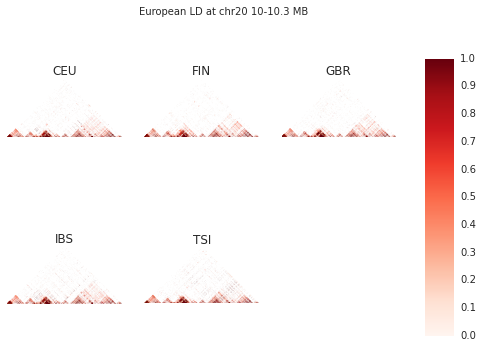

In [10]:
plot_ld_figure(chr20_region_ld_results["EUR"], "European LD at chr20 10-10.3 MB")

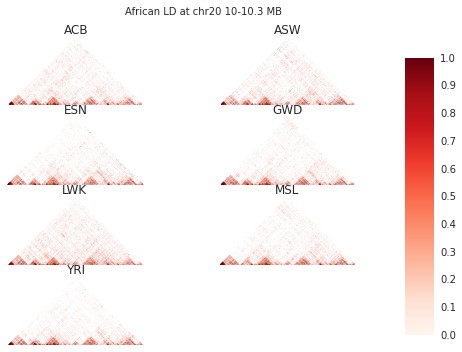

In [11]:
plot_ld_figure(chr20_region_ld_results["AFR"], "African LD at chr20 10-10.3 MB")

In stark contrast, the region surrounding the LCT and MCM6 genes, which is a region that has experienced positive selection for its ability to confer lactase persistence, shows evidence of substantial long-range LD. This is visually depicted by the large red triangle in the LD plots of the region. 

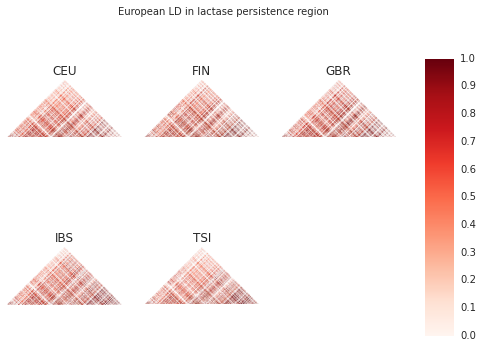

In [12]:
plot_ld_figure(lactase_region_ld_results["EUR"], "European LD in lactase persistence region")

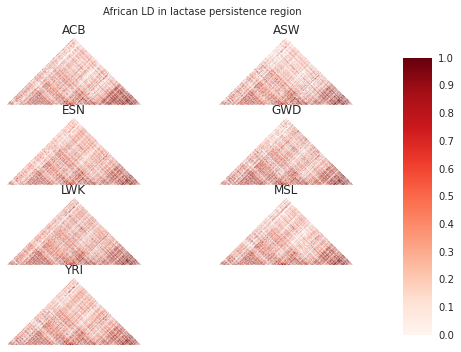

In [13]:
plot_ld_figure(lactase_region_ld_results["AFR"], "African LD in lactase persistence region")

While there is meaningful long-range LD in all populations examined here, the LD results in the lactase persistence region are visibly less intense in the African subpopulations than in the European subpopulations. This is expected given the evidence for strong positive selection in Europeans in the region.